In [1]:

from __future__ import absolute_import, division, print_function

import pprint
import argparse
import logging
import os
import random
import sys
import pickle
import copy
import collections
import math

import numpy as np
import numpy
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler,TensorDataset

from torch.nn import CrossEntropyLoss, MSELoss

from transformer import BertForSequenceClassification,WEIGHTS_NAME, CONFIG_NAME
from transformer.modeling_quant import BertForSequenceClassification as QuantBertForSequenceClassification
from transformer import BertTokenizer
from transformer import BertAdam
from transformer import BertConfig
from transformer import QuantizeLinear, QuantizeAct, BertSelfAttention, FP_BertSelfAttention, ClipLinear
from utils_glue import *
from bertviz import model_view

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch.nn.functional as F

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0 
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def do_eval(model, task_name, eval_dataloader,
            device, output_mode, eval_labels, num_labels, teacher_model=None):
    eval_loss = 0
    nb_eval_steps = 0
    preds = []

    for batch_ in tqdm(eval_dataloader, desc="Inference"):
        batch_ = tuple(t.to(device) for t in batch_)
        
        with torch.no_grad():
            input_ids, input_mask, segment_ids, label_ids, seq_lengths = batch_

            # teacher attnmap test
            if teacher_model is not None:
                
                # logits, _, teacher_reps, teacher_probs, teacher_values = teacher_model(input_ids, segment_ids, input_mask)
                
                # # logits, _, _, _, _ = model(input_ids, segment_ids, input_mask, teacher_probs=teacher_probs)
                # logits, _, _, _, _ = model(input_ids, segment_ids, input_mask, teacher_probs=(teacher_probs, teacher_values, teacher_reps))
                teacher_logits, teacher_atts, teacher_reps, teacher_probs, teacher_values = teacher_model(input_ids, segment_ids, input_mask)
                logits, student_atts, student_reps, student_probs, student_values  = model(input_ids, segment_ids, input_mask, teacher_outputs=(teacher_probs, teacher_values, teacher_reps, teacher_logits, teacher_atts), output_mode=output_mode, seq_lengths=seq_lengths)
            else:
                logits, _, _, _, _ = model(input_ids, segment_ids, input_mask)
        
        # create eval loss and other metric required by the task
        if output_mode == "classification":
            loss_fct = CrossEntropyLoss()
            tmp_eval_loss = loss_fct(logits.view(-1, num_labels), label_ids.view(-1))
        elif output_mode == "regression":
            loss_fct = MSELoss()
            tmp_eval_loss = loss_fct(logits.view(-1), label_ids.view(-1))

        eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1
        if len(preds) == 0:
            preds.append(logits.detach().cpu().numpy())
        else:
            preds[0] = np.append(
                preds[0], logits.detach().cpu().numpy(), axis=0)

    eval_loss = eval_loss / nb_eval_steps

    preds = preds[0]
    if output_mode == "classification":
        preds = np.argmax(preds, axis=1)
    elif output_mode == "regression":
        preds = np.squeeze(preds)
    result = compute_metrics(task_name, preds, eval_labels.numpy())
    result['eval_loss'] = eval_loss
    return result

processors = {
    "cola": ColaProcessor,
    "mnli": MnliProcessor,
    "mnli-mm": MnliMismatchedProcessor,
    "mrpc": MrpcProcessor,
    "sst-2": Sst2Processor,
    "sts-b": StsbProcessor,
    "qqp": QqpProcessor,
    "qnli": QnliProcessor,
    "rte": RteProcessor   
}

output_modes = {
        "cola": "classification",
        "mnli": "classification",
        "mrpc": "classification",
        "sst-2": "classification",
        "sts-b": "regression",
        "qqp": "classification",
        "qnli": "classification",
        "rte": "classification"
}

default_params = {
        "cola": {"max_seq_length": 64,"batch_size":1,"eval_step": 50}, # No Aug : 50 Aug : 400
        "mnli": {"max_seq_length": 128,"batch_size":1,"eval_step":8000},
        "mrpc": {"max_seq_length": 128,"batch_size":1,"eval_step":100},
        "sst-2": {"max_seq_length": 64,"batch_size":1,"eval_step":100},
        "sts-b": {"max_seq_length": 128,"batch_size":1,"eval_step":100},
        "qqp": {"max_seq_length": 128,"batch_size":1,"eval_step":1000},
        "qnli": {"max_seq_length": 128,"batch_size":1,"eval_step":1000},
        "rte": {"max_seq_length": 128,"batch_size":1,"eval_step": 20}
    }

def get_tensor_data(output_mode, features):
    if output_mode == "classification":
        all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    elif output_mode == "regression":
        all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.float)


    all_seq_lengths = torch.tensor([f.seq_length for f in features], dtype=torch.long)
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    tensor_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,all_label_ids, all_seq_lengths)
    return tensor_data, all_label_ids


In [2]:
task_name = "cola"
bert_size = "base"

if bert_size == "large":
    layer_num = 24
    head_num = 16
else: 
    layer_num = 12
    head_num = 12
    
teacher_model = None

# torch.cuda.empty_cache()
# !nvidia-smi

# Device & Dataset

In [3]:
device = "cpu"

model_dir = "models"
output_dir = "output"

if bert_size == "large":
    model_dir = os.path.join(model_dir, "BERT_large")
    output_dir = os.path.join(output_dir, "BERT_large")

teacher_model_dir = os.path.join(model_dir,task_name)

# Processor & Task Info
processor = processors[task_name]()
output_mode = output_modes[task_name]
label_list = processor.get_labels()
num_labels = len(label_list)

if task_name in default_params:
    batch_size = default_params[task_name]["batch_size"]
    max_seq_length = default_params[task_name]["max_seq_length"]
    eval_step = default_params[task_name]["eval_step"]
    
# Tokenizer
tokenizer = BertTokenizer.from_pretrained(teacher_model_dir, do_lower_case=True)


# Load Dataset
data_dir = os.path.join("data",task_name)
processed_data_dir = os.path.join(data_dir,'preprocessed')

eval_examples = processor.get_dev_examples(data_dir)
eval_features = convert_examples_to_features(eval_examples, label_list, max_seq_length, tokenizer, output_mode)
# dev_file = train_file = os.path.join(processed_data_dir,'dev.pkl') 
# eval_features = pickle.load(open(dev_file,'rb'))

eval_data, eval_labels = get_tensor_data("regression", eval_features)
eval_sampler = SequentialSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=1)
eval_data, eval_labels = get_tensor_data(output_mode, eval_features)

eval_examples = processor.get_dev_examples(data_dir)

# Sampling Sentence 
i = 0 
# num = 3
num = 12

for step, batch in enumerate(eval_dataloader):
    # model.train()
            
    batch = tuple(t.to(device) for t in batch)
    input_ids, input_mask, segment_ids, label_ids, seq_lengths = batch
    seq_length = seq_lengths[0]
    i = i + 1
    if i == num:
        break

input_ids_sliced = input_ids[:,:seq_length]
input_id = []
for i in input_ids_sliced[0]:
    input_id.append(i.item())
tokens = tokenizer.convert_ids_to_tokens(input_id)


sample_sentence_a = str()
sample_sentence_b = str()
index = 0

for i, word in enumerate(tokens[1:-1]):
    if word == "[SEP]":
        break
    sample_sentence_a += word
    sample_sentence_a += " "
index = i

for i, word in enumerate(tokens[index+2:-1]):
    if word == "[SEP]":
        break
    sample_sentence_b += word
    sample_sentence_b += " "

sep_index = torch.where(input_ids[0] == 102)[0]

punc_index_1 = torch.where(input_ids[0] == 1010)[0] # comma
punc_index_2 = torch.where(input_ids[0] == 1012)[0] # period
punc_index = torch.cat([punc_index_1, punc_index_2])

if len(sample_sentence_b) > 1:
    sample_sentence_b_start = segment_ids[0].tolist().index(1)
else:
    sample_sentence_b_start = None

print(f"input_ids : {input_ids_sliced}")
print(f"tokens : {tokens}")
print(f"A : {sample_sentence_a}")
print(f"B : {sample_sentence_b}")
print(sep_index)
print("PUNC")
print(f"comma -> {punc_index_1}")
print(f"period -> {punc_index_2}")

for i, token in enumerate(tokens):
    tokens[i] = token # + "_" + str(i)


10/06 10:10:18 AM Writing example 0 of 1043
10/06 10:10:18 AM *** Example ***
10/06 10:10:18 AM guid: dev-0
10/06 10:10:18 AM tokens: [CLS] the sailors rode the breeze clear of the rocks . [SEP]
10/06 10:10:18 AM input_ids: 101 1996 11279 8469 1996 9478 3154 1997 1996 5749 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
10/06 10:10:18 AM input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
10/06 10:10:18 AM segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
10/06 10:10:18 AM label: 1
10/06 10:10:18 AM label_id: 1
input_ids : tensor([[  101,  2198,  2001,  7167,  2062, 27885,  3630, 25171,  2084,  5965,
          1012,   102]])
tokens : ['[CLS]', 'john', 'was', 'lots', 'more', 'ob', '##no', '##xious', 'than', 'fred', '.', '[SEP]']
A : john was lots 

In [1673]:
def ranking_loss_func(student_probs, teacher_probs):
    Loss_ranking = 0

    loss_ranking_list = []

    for l in tqdm(range(layer_num)):
        for h in range(head_num):
            student_prob_plt = student_probs[l][0,h,:,:]
            teacher_prob_plt = teacher_probs[l][0,h,:,:]
            Loss_ranking = 0
            for h in range(seq_length):
                for idx in range(0, seq_length-1):
                    for jdx in range(1, seq_length):
                        p = (student_prob_plt[h][idx] - student_prob_plt[h][jdx])*(torch.sgn(teacher_prob_plt[h][idx] - teacher_prob_plt[h][jdx]))
                        # print(max(0,  - p.item()))
                        Loss_ranking += max(0,  - p.item())
            loss_ranking_list.append(Loss_ranking)
    return loss_ranking_list

In [4]:
device = torch.device("cpu")

teacher_model = BertForSequenceClassification.from_pretrained(teacher_model_dir, num_labels=num_labels)
teacher_model.to(device)
teacher_model.eval()


teacher_logits, teacher_atts, teacher_reps, teacher_probs, teacher_zip = teacher_model(input_ids_sliced.to(device))
teacher_outputs = (teacher_probs, teacher_zip)


In [21]:
file_name= "step_2_base_S_O_1_MIXED"
student_model_dir = os.path.join("output", task_name, "exploration", file_name)
student_config_OI = BertConfig.from_pretrained(student_model_dir)
# student_config_OI.teacher_attnmap = False
student_model = QuantBertForSequenceClassification.from_pretrained(student_model_dir, config = student_config_OI, num_labels=num_labels)

model_2_outputs  = student_model(input_ids_sliced.to(device), teacher_outputs=teacher_outputs)


In [22]:
file_name= "step_2_base_S_O_1_OI"
student_model_dir = os.path.join("output", task_name, "exploration", file_name)
student_config_MIXED = BertConfig.from_pretrained(student_model_dir)
# student_config_MIXED.teacher_attnmap = False
# student_config_MIXED.teacher_output = False
student_model = QuantBertForSequenceClassification.from_pretrained(student_model_dir, config = student_config_MIXED, num_labels=num_labels)

model_3_outputs  = student_model(input_ids_sliced.to(device), teacher_outputs=teacher_outputs)


In [23]:
file_name= "step_2_base_S_O_1_MI"
student_model_dir = os.path.join("output", task_name, "exploration", file_name)
student_config_MIXED = BertConfig.from_pretrained(student_model_dir)
# student_config_MIXED.teacher_attnmap = False
# student_config_MIXED.teacher_output = False
student_model = QuantBertForSequenceClassification.from_pretrained(student_model_dir, config = student_config_MIXED, num_labels=num_labels)

model_4_outputs  = student_model(input_ids_sliced.to(device), teacher_outputs=teacher_outputs)



In [24]:




# student_logits, student_atts, student_reps_1, student_probs_1, student_zip_1  = model_1_outputs
student_logits, student_atts, student_reps_2, student_probs_2, student_zip_2  = model_2_outputs
student_logits, student_atts, student_reps_3, student_probs_3, student_zip_3  = model_3_outputs
student_logits, student_atts, student_reps_4, student_probs_4, student_zip_4  = model_4_outputs

# model_outputs = (model_1_outputs, model_2_outputs, model_3_outputs, model_4_outputs)
model_outputs = (model_2_outputs, model_3_outputs, model_4_outputs)

In [25]:
mag_dict = dict()

for model_num in range(4):
    for l in range(layer_num):        
        mag_dict[f"{model_num}_min_{l}"] = []; mag_dict[f"{model_num}_max_{l}"] = []; mag_dict[f"{model_num}_std_{l}"] = []; mag_dict[f"{model_num}_mean_{l}"] = []
        if model_num == 0:
            mag_dict[f"tc_min_{l}"] = []; mag_dict[f"tc_max_{l}"] = []; mag_dict[f"tc_std_{l}"] = []; mag_dict[f"tc_mean_{l}"] = []

In [26]:
model_num = 0
mse_func = MSELoss()
cos_func = torch.nn.CosineSimilarity(dim=-1)

for model_output in model_outputs:
    
    student_logits, student_atts, student_reps, student_probs, student_zip = model_output
    mag_dict[f"{model_num}_ffn_mse"] = []; mag_dict[f"{model_num}_attn_cos"] = []; mag_dict[f"{model_num}_attn_mse"] = []; mag_dict[f"{model_num}_ffn_cos"] = []
    for l in range(layer_num):
        tc_attn_context, tc_attn_output, tc_sa_output = teacher_zip[l]
        st_attn_context, st_attn_output, st_sa_output = student_zip[l]        
        st_ffn_output = student_reps[1+1]
        tc_ffn_output = teacher_reps[l+1]

        tc_output = tc_ffn_output
        st_output = st_ffn_output
    
        # min-max
        for token in range(len(tokens)):
            if model_num == 0:
                mag_dict[f"tc_min_{l}"].append(tc_output[0,token,:].min().item())
                mag_dict[f"tc_max_{l}"].append(tc_output[0,token,:].max().item())
                mag_dict[f"tc_mean_{l}"].append(tc_output[0,token,:].mean().item())
                mag_dict[f"tc_std_{l}"].append(tc_output[0,token,:].std().item())
                
#                 mag_dict[f"tc_min_{l}"].append(tc_output[0,:,token,:].min().item())
#                 mag_dict[f"tc_max_{l}"].append(tc_output[0,:,token,:].max().item())
#                 mag_dict[f"tc_mean_{l}"].append(tc_output[0,:,token,:].mean().item())
#                 mag_dict[f"tc_std_{l}"].append(tc_output[0,:,token,:].std().item())

            mag_dict[f"{model_num}_min_{l}"].append(st_output[0,token,:].min().item())
            mag_dict[f"{model_num}_max_{l}"].append(st_output[0,token,:].max().item())
            mag_dict[f"{model_num}_mean_{l}"].append(st_output[0,token,:].mean().item())
            mag_dict[f"{model_num}_std_{l}"].append(st_output[0,token,:].std().item())

#             mag_dict[f"{model_num}_min_{l}"].append(st_output[0,:,token,:].min().item())
#             mag_dict[f"{model_num}_max_{l}"].append(st_output[0,:,token,:].max().item())
#             mag_dict[f"{model_num}_mean_{l}"].append(st_output[0,:,token,:].mean().item())
#             mag_dict[f"{model_num}_std_{l}"].append(st_output[0,:,token,:].std().item())            
                
            
        
        mse_attn_diff = mse_func(st_attn_output[0,:,:], tc_attn_output[0,:,:]).item()
        cos_attn_diff = torch.mean((1-cos_func(st_attn_output[0,:,:], tc_attn_output[0,:,:]))).item()
        mag_dict[f"{model_num}_attn_mse"].append(mse_attn_diff)
        mag_dict[f"{model_num}_attn_cos"].append(cos_attn_diff)

        mse_ffn_diff = mse_func(student_reps[l+1][0,:,:], teacher_reps[l+1][0,:,:]).item()
        cos_ffn_diff = torch.mean((1-cos_func(student_reps[l+1][0,:,:], teacher_reps[l+1][0,:,:]))).item()
        mag_dict[f"{model_num}_ffn_mse"].append(mse_ffn_diff)
        mag_dict[f"{model_num}_ffn_cos"].append(cos_ffn_diff)

    model_num += 1

In [1491]:
st_map = student_probs[0]
tc_map = teacher_probs[0]

kl_loss = torch.nn.KLDivLoss(reduction="batchmean")

kl_loss(st_map[0,0,:,:].log(), tc_map[0,0,:,:])

tensor(0.0517, grad_fn=<DivBackward0>)

In [1680]:
model_num = 0
mse_func = MSELoss()
cos_func = torch.nn.CosineSimilarity(dim=-1)
kl_loss = torch.nn.KLDivLoss(reduction="batchmean")

context_similarity = torch.randn(2,layer_num, head_num)
cont_dict = dict()
cont_dict["0_cont"] = []
cont_dict["1_cont"] = []

cont_dict["0_sa"] = []
cont_dict["1_sa"] = []

map_similarity = torch.randn(2,layer_num, head_num)

for model_output in model_outputs:
    
    student_logits, student_atts, student_reps, student_probs, student_zip = model_output
    for l in range(layer_num):
        tc_attn_context, tc_attn_output, tc_sa_output = teacher_zip[l]
        st_attn_context, st_attn_output, st_sa_output = student_zip[l]        
        st_ffn_output = student_reps[1+1]
        tc_ffn_output = teacher_reps[l+1]
        
        sa_diff = mse_func(tc_sa_output, st_sa_output)
        cont_dict[f"{model_num}_sa"].append(sa_diff.item())

        st_map = student_probs[1]
        tc_map = teacher_probs[l]

        tc_output = tc_attn_context
        st_output = st_attn_context
        
        for h in range(head_num):
            cos_sim = cos_func(tc_output[0,h,:,:], st_output[0,h,:,:]).mean()
            context_similarity[model_num][l,h] = 1 - cos_sim
            
            cont_dict[f"{model_num}_cont"].append((1-cos_sim).item())
            
            map_sim = kl_loss(st_map[0,h,:,:].log(), tc_map[0,h,:,:])
            map_similarity[model_num][l,h] = map_sim
            
    model_num += 1

In [56]:
mag_dict = torch.load("sts-b-step-2")

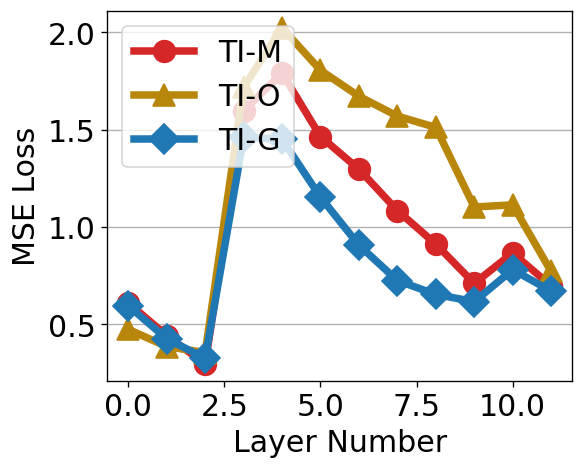

In [57]:

lw = 4.5
ms = 13
layer_num = 12
label_1 = "TI-M"
label_2 = "TI-O"
label_3 = "TI-G"
label_4 = "Q"
sub = "attn"

fig, ax1 = plt.subplots(1, 1, figsize=(5, 4), dpi=120)
plt.grid(axis="y")
ax1.plot(list(range(layer_num)), mag_dict[f"0_{sub}_mse"], label=label_1, color="tab:red", linewidth=lw, marker="o", markersize=ms)
ax1.plot(list(range(layer_num)), mag_dict[f"1_{sub}_mse"], label=label_2, color="darkgoldenrod", linewidth=lw, marker="^", markersize=ms)
ax1.plot(list(range(layer_num)), mag_dict[f"2_{sub}_mse"], label=label_3, color="tab:blue", linewidth=lw, marker="D", markersize=ms)
# ax1.plot(list(range(layer_num)), mag_dict[f"3_{sub}_mse"], label=label_4, color="tab:orange", linewidth=lw, marker="D", markersize=ms)
# ax1.set_title(f"Attention Output Loss per-layer", fontsize=20)

# fig, ax2 = plt.subplots(1, 1, figsize=(12, 7), dpi=50)
# sub = "ffn"
# plt.grid(axis="y")
# # ax2.plot(list(range(layer_num)), mag_dict[f"3_{sub}_mse"], label=label_4, color="dimgray", linewidth=lw, marker="D", markersize=ms)
# ax2.plot(list(range(layer_num)), mag_dict[f"0_{sub}_mse"], label=label_1, color="tab:blue", linewidth=lw, marker="^", markersize=ms)
# ax2.plot(list(range(layer_num)), mag_dict[f"1_{sub}_mse"], label=label_2, color="darkblue", linewidth=lw, marker="o", markersize=ms)
# ax2.plot(list(range(layer_num)), mag_dict[f"2_{sub}_mse"], label=label_3, color="tab:blue", linewidth=lw, marker="D", markersize=ms)

# ax2.set_title(f"Attention {sub} Output per-layer", fontsize=20)

#     ax2.plot(list(range(layer_num)), mag_dict[f"0_{sub}_cos"], label=f"MI-COS", color="tab:red", linewidth=lw, marker="o", markersize=ms)
#     ax2.plot(list(range(layer_num)), mag_dict[f"1_{sub}_cos"], label=f"OI-COS", color="darkgoldenrod", linewidth=lw, marker="^", markersize=ms)
#     ax2.plot(list(range(layer_num)), mag_dict[f"2_{sub}_cos"], label=f"MIXED-COS", color="tab:blue", linewidth=lw, marker="D", markersize=ms)

#     ax3.set_title(f"FFN Output Layer {l}", fontsize=20)
#     ax3.plot(list(range(len(tokens))), mag_dict[f"0_ffn_mse_{l}"], label="1SB_M_ffn_mse", color="orange", linewidth=2.5)
#     ax3.plot(list(range(len(tokens))), mag_dict[f"1_ffn_mse_{l}"], label="1SB_O_ffn_mse", color="dodgerblue", linewidth=2.5)

#     ax4.plot(list(range(len(tokens))), mag_dict[f"0_ffn_cos_{l}"], label="1SB_M_ffn_cos", color="orange", linewidth=2.5)
#     ax4.plot(list(range(len(tokens))), mag_dict[f"1_ffn_cos_{l}"], label="1SB_O_ffn_cos", color="dodgerblue", linewidth=2.5)

fs=18
ax1.legend(loc=2, fontsize=fs)
# ax2.legend(loc=2, fontsize=18)
ax1.set_xlabel("Layer Number", fontsize=fs)
ax1.set_ylabel(f"MSE Loss", fontsize=fs)
ax1.tick_params(axis="x", labelsize=fs)
# ax2.tick_params(axis="x", labelsize=22)
ax1.tick_params(axis="y", labelsize=fs)
# ax2.tick_params(axis="y", labelsize=22)

    #     ax3.legend(loc=2, fontsize=15)
    #     ax4.legend(loc=2, fontsize=15)

plt.show()


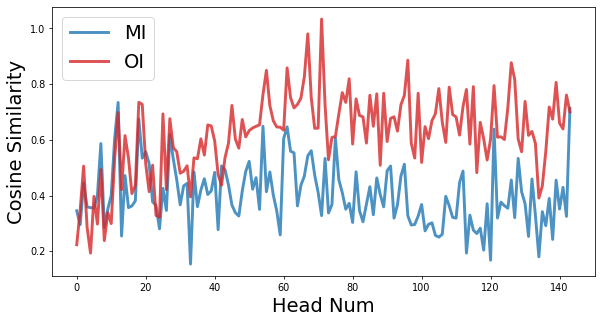

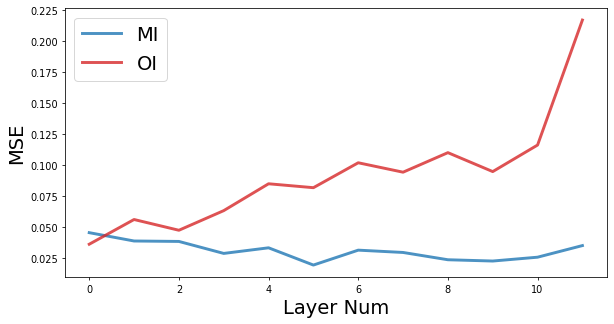

In [1681]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=70)
fs=20
lw=3

ax.plot(list(range(layer_num*head_num)), cont_dict["0_cont"], label="MI", color="tab:blue", linewidth=lw, alpha=0.8)
ax.plot(list(range(layer_num*head_num)), cont_dict["1_cont"], label="OI", color="tab:red", linewidth=lw, alpha=0.8)
plt.legend(fontsize=fs)
ax.set_xlabel("Head Num", fontsize=fs)
ax.set_ylabel("Cosine Similarity", fontsize=fs)

fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=70)
fs=20
lw=3

ax.plot(list(range(layer_num)), cont_dict["0_sa"], label="MI", color="tab:blue", linewidth=lw, alpha=0.8)
ax.plot(list(range(layer_num)), cont_dict["1_sa"], label="OI", color="tab:red", linewidth=lw, alpha=0.8)
ax.set_xlabel("Layer Num", fontsize=fs)
ax.set_ylabel("MSE", fontsize=fs)
plt.legend(fontsize=fs)


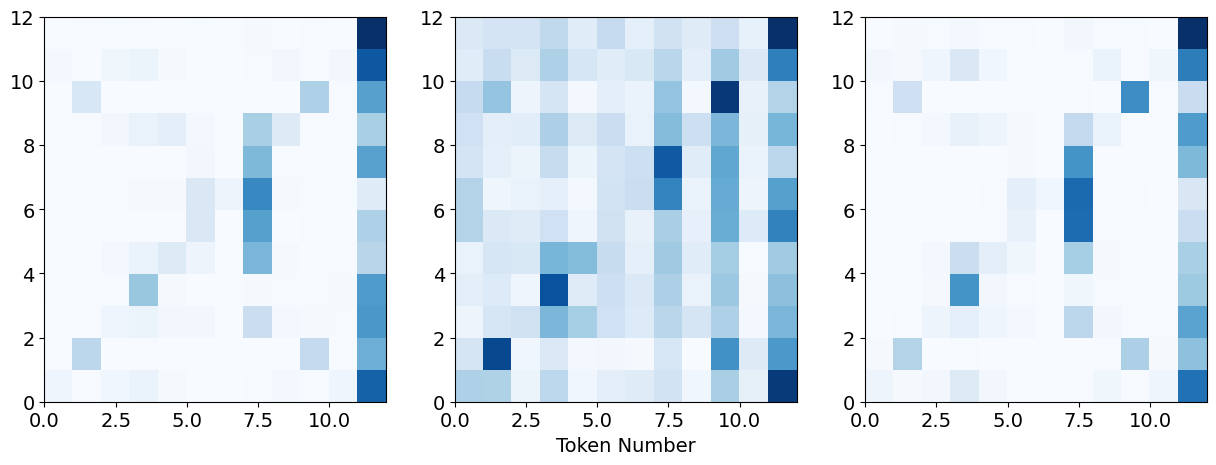

In [1722]:

l=9
h=0    
st_map_1 = model_outputs[0][-2][l]
st_map_2 = model_outputs[1][-2][l]
tc_map = teacher_probs[l]

fs=20

fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(15, 5))

# ax1.set_title(f"layer {l}-{h}th head Teacher", fontsize=fs)
# ax2.set_title(f"layer {l}-{h}th head OI + map", fontsize=fs)
# ax3.set_title(f"layer {l}-{h}th head OI", fontsize=fs)

ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)

ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.set_xlabel("Token Number", fontsize=14)
ax3.tick_params(axis='x', labelsize=14)
ax3.tick_params(axis='y', labelsize=14)

heatmap = ax1.pcolor(tc_map[0,h,:,:].detach().numpy(), cmap=plt.cm.Blues)
heatmap = ax2.pcolor(st_map_2[0,h,:,:].detach().numpy(), cmap=plt.cm.Blues)
heatmap = ax3.pcolor(st_map_1[0,h,:,:].detach().numpy(), cmap=plt.cm.Blues)


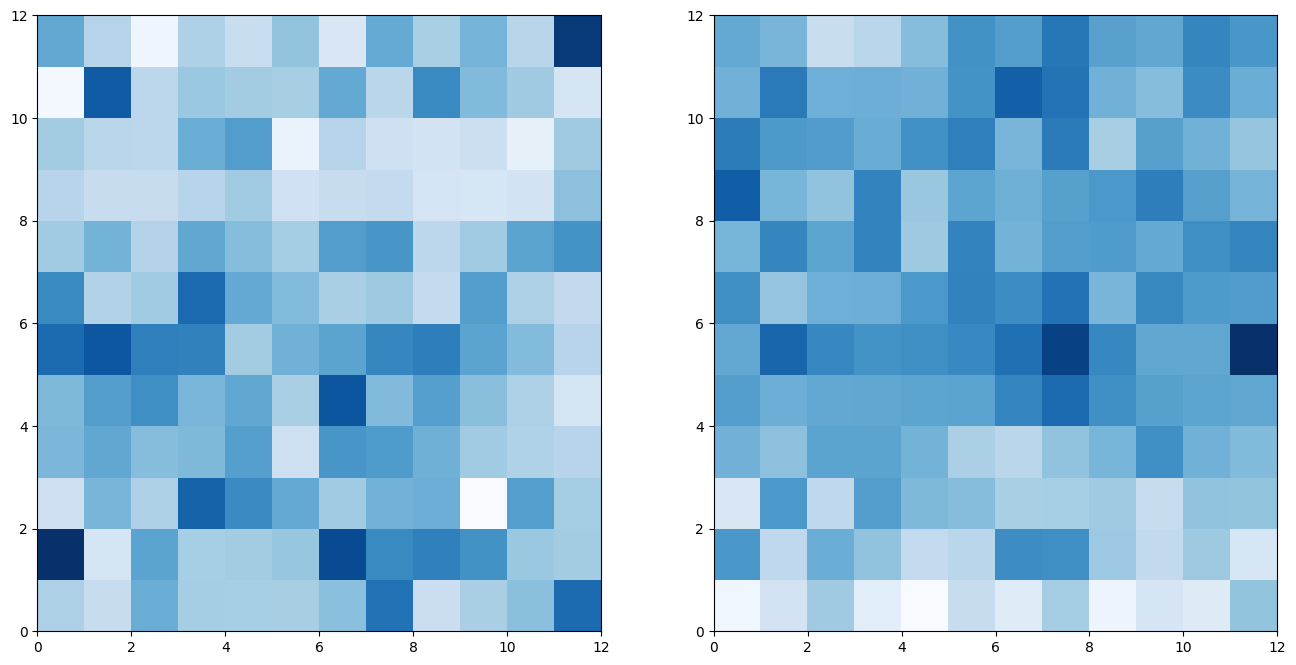

In [1683]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16,8))

heatmap = ax1.pcolor(context_similarity[0].detach().numpy(), cmap=plt.cm.Blues)
heatmap = ax2.pcolor(context_similarity[1].detach().numpy(), cmap=plt.cm.Blues)

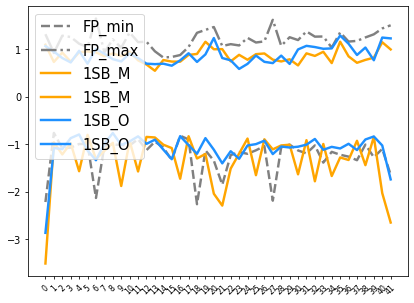

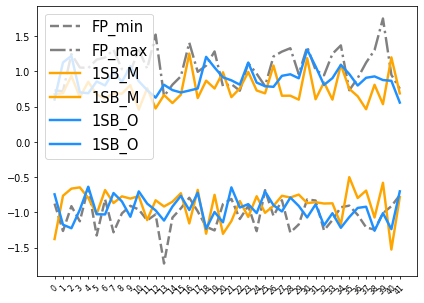

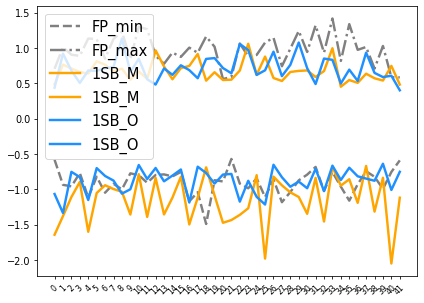

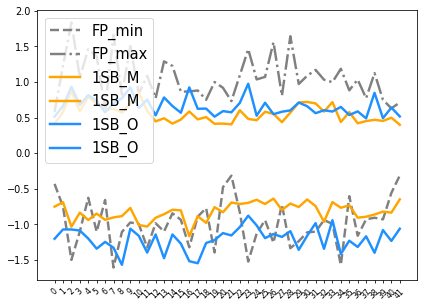

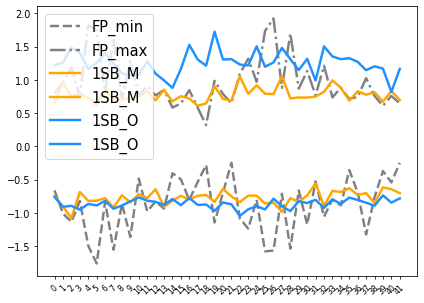

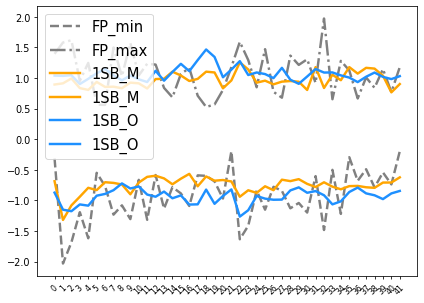

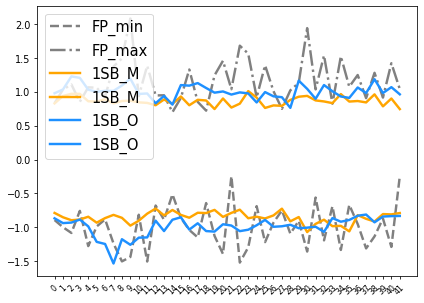

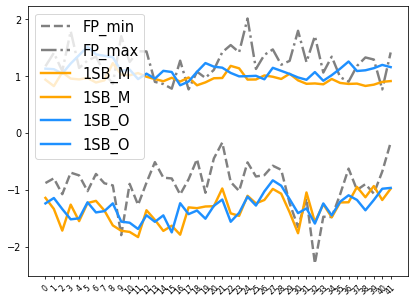

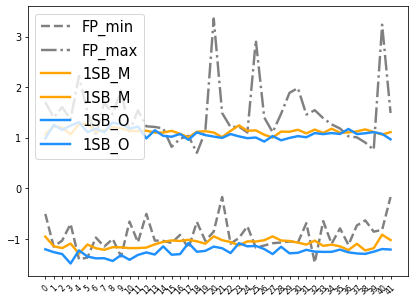

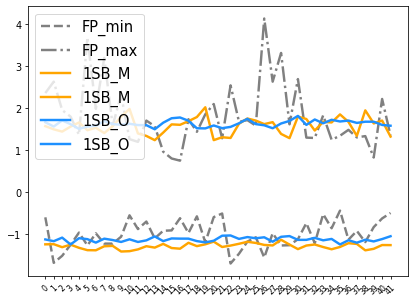

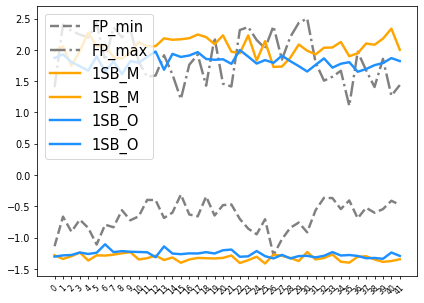

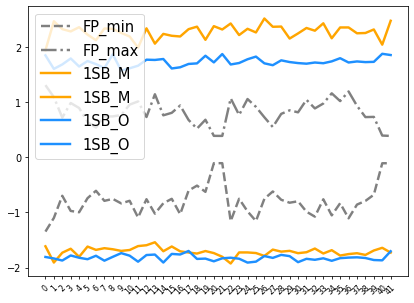

In [1657]:
for l in range(layer_num):

    fig, ax = plt.subplots(1, 1, figsize=(7, 5), dpi=70)
    ax.plot(list(range(len(tokens))), mag_dict[f"tc_min_{l}"], label="FP_min", color="gray", linewidth=2.5, linestyle="--")
    ax.plot(list(range(len(tokens))), mag_dict[f"tc_max_{l}"], label="FP_max", color="gray", linewidth=2.5, linestyle="-.")
    # ax.plot(tokens, mag_dict[f"tc_mean_{l}"], label="tc_mean", color="r")

    ax.plot(list(range(len(tokens))), mag_dict[f"0_min_{l}"], label="1SB_M", color="orange", linewidth=2.5)
    ax.plot(list(range(len(tokens))), mag_dict[f"0_max_{l}"], label="1SB_M", color="orange", linewidth=2.5)

    ax.plot(list(range(len(tokens))), mag_dict[f"1_min_{l}"], label="1SB_O", color="dodgerblue", linewidth=2.5)
    ax.plot(list(range(len(tokens))), mag_dict[f"1_max_{l}"], label="1SB_O", color="dodgerblue", linewidth=2.5)

    # ax.plot(tokens, mag_dict[f"2_min_{l}"], label="1SB_LSM_M", color="b", linestyle="-.")
    # ax.plot(tokens, mag_dict[f"2_max_{l}"], label="1SB_LSM_M", color="b", linestyle="-.")
    # ax.plot(tokens, mag_dict[f"{model_num}_mean_{l}"], label="st_mean", color="dodgerblue")
    # ax.set_tit#le(f"FFN Output Layer {l}", fontsize=20)
    ax.legend(loc=2, fontsize=15)
    plt.xticks(range(len(tokens)),rotation=45, fontsize=8)
    # ax.set_xlabel("Token Number", fontsize=20)
    plt.show()

In [1217]:
# model_num = 0
# for l in range(layer_num):

#     fig, ax = plt.subplots(1, 1, figsize=(15, 5), dpi=50)
#     ax.plot(list(range(len(tokens))), mag_dict[f"tc_min_{l}"], label="FP_min", color="gray", linewidth=2.5, linestyle="--")
#     ax.plot(list(range(len(tokens))), mag_dict[f"tc_max_{l}"], label="FP_max", color="gray", linewidth=2.5, linestyle="-.")

#     ax.plot(list(range(len(tokens))), mag_dict[f"0_min_{l}"], label="MI", color="tab:orange", linewidth=2.5)
#     ax.plot(list(range(len(tokens))), mag_dict[f"0_max_{l}"], label="MI", color="tab:orange", linewidth=2.5)
    
#     ax.plot(list(range(len(tokens))), mag_dict[f"1_min_{l}"], label="MIXED", color="tab:blue", linewidth=2.5)
#     ax.plot(list(range(len(tokens))), mag_dict[f"1_max_{l}"], label="MIXED", color="tab:blue", linewidth=2.5)
    
#     ax.plot(list(range(len(tokens))), mag_dict[f"2_min_{l}"], label="OI", color="darkgoldenrod", linewidth=2.5)
#     ax.plot(list(range(len(tokens))), mag_dict[f"2_max_{l}"], label="OI", color="darkgoldenrod", linewidth=2.5)

#     ax.plot(list(range(len(tokens))), mag_dict[f"3_min_{l}"], label="OI", color="r", linewidth=2.5)
#     ax.plot(list(range(len(tokens))), mag_dict[f"3_max_{l}"], label="OI", color="r", linewidth=2.5)
    
#     ax.set_title(f"ATTN Output Layer {l}", fontsize=20)
#     ax.legend(loc=2, fontsize=15)
#     plt.xticks(range(len(tokens)),rotation=45, fontsize=8)
#     # ax.set_xlabel("Token Number", fontsize=20)
#     plt.show()
#     # break




In [1684]:
st_2 = ranking_loss_func(student_probs_2, teacher_probs)
st_3 = ranking_loss_func(student_probs_3, teacher_probs)
# st_4 = ranking_loss_func(student_probs_4, teacher_probs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.30it/s]


Text(0, 0.5, 'Ranking Loss(CoLA)')

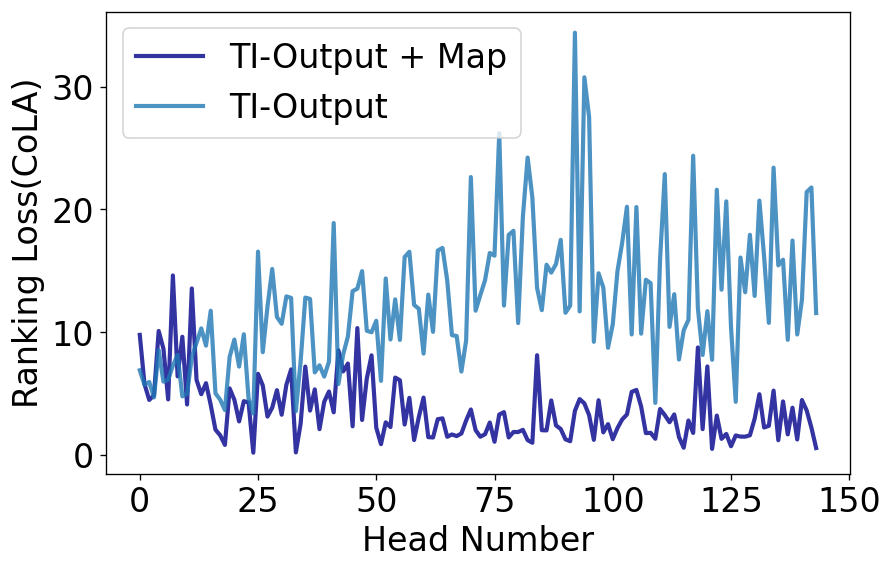

In [1717]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=120)
fs=20
lw=2.5
# ax.plot(list(range(layer_num*head_num)), st_1, label="Direct Q", color="tab:red", linewidth=lw, alpha=1)
ax.plot(list(range(layer_num*head_num)), st_2, label="TI-Output + Map", color="darkblue", linewidth=lw, alpha=0.8)
ax.plot(list(range(layer_num*head_num)), st_3, label="TI-Output", color="tab:blue", linewidth=lw, alpha=0.8)
# ax.plot(list(range(layer_num*head_num)), st_4, label="Ternary", color="tab:orange", linewidth=lw, alpha=0.8)

ax.tick_params(axis="x", labelsize=fs)
ax.tick_params(axis="y", labelsize=fs)
ax.legend(fontsize=fs, loc=2)
ax.set_xlabel("Head Number", fontsize=fs)
ax.set_ylabel(f"Ranking Loss(CoLA)", fontsize=fs)


In [1318]:
cover_mean_check = True
kl_div_check = True
student_probs = student_probs_2
exclude_sep = False
layer_num = 4
if cover_mean_check:
    print("COVER MEAN CHECK")
    top_k = 5

    for i in range(layer_num):
        teacher = teacher_probs[i][0]
        student = student_probs[i][0]

        head_sum = 0
        for h in range(head_num):
            coverage_head_sum = 0
            for row in range(seq_length-1):
                if exclude_sep:
                    tc_argsort = teacher[h][:seq_length-1,:seq_length-1].sort(descending=True)[1][row][:top_k] # top-k
                    st_argsort = student[h][:seq_length-1,:seq_length-1].sort(descending=True)[1][row]
                tc_argsort = teacher[h].sort(descending=True)[1][row][:top_k] # top-k
                st_argsort = student[h].sort(descending=True)[1][row]

                max_idx = 0
                for idx in tc_argsort:
                    tmp = torch.where(st_argsort == idx)
                    max_idx = max(tmp[0].item(), max_idx)

                coverage_ratio = max_idx / student.shape[1]
                coverage_head_sum += coverage_ratio

                # print(f"H{h} : {coverage_head_sum/seq_length}")

            head_sum += coverage_head_sum / seq_length
        print((head_sum / head_num).item())

if kl_div_check:
    print("KL DIV CHECK")
    for i in range(layer_num):
        if exclude_sep:
            if len(sep_index) == 2:
                teacher_atts[i][:,:,:,sep_index[0]] = -100000; teacher_atts[i][:,:,:,sep_index[1]] = -100000
                student_atts[i][:,:,:,sep_index[0]] = -100000; student_atts[i][:,:,:,sep_index[1]] = -100000
            else:
                teacher_atts[i][:,:,:,sep_index[0]] = -100000
                student_atts[i][:,:,:,sep_index[0]] = -100000
                
            teacher = torch.nn.Softmax(dim=-1)(teacher_atts[i])
            student = torch.nn.Softmax(dim=-1)(student_atts[i])
            
            student = torch.clamp_min(student, 1e-8)
            teacher = torch.clamp_min(teacher, 1e-8)
        else:    
            teacher = teacher_probs[i]
            student = student_probs[i]
        
        neg_cross_entropy = teacher * torch.log(student) 
        neg_cross_entropy = torch.sum(neg_cross_entropy, dim=-1)  # (b, h, s, s) -> (b, h, s)
        neg_cross_entropy = torch.sum(neg_cross_entropy, dim=-1) / seq_lengths.view(-1, 1)  # (b, h, s) -> (b, h)

        # p(t) log p(t) = negative entropy
        neg_entropy = teacher * torch.log(teacher) 
        neg_entropy = torch.sum(neg_entropy, dim=-1)  # (b, h, s, s) -> (b, h, s)
        neg_entropy = torch.sum(neg_entropy, dim=-1) / seq_lengths.view(-1, 1)  # (b, h, s) -> (b, h)

        kld_loss = neg_entropy - neg_cross_entropy

        kld_loss_sum = torch.sum(kld_loss)
        print(kld_loss_sum.item())



COVER MEAN CHECK
0.7350823283195496
0.6579217910766602
0.6787551045417786
0.654063880443573
KL DIV CHECK
21.967914581298828
27.941110610961914
21.092199325561523
14.090266227722168


device(type='cuda', index=0)

# Per Layer Comp

In [36]:
cos_func = torch.nn.CosineSimilarity(dim=-1)
mag_dict = dict()
seed=42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
mse_func = MSELoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_dir = "models"
output_dir = "output"

if bert_size == "large":
    model_dir = os.path.join(model_dir, "BERT_large")
    output_dir = os.path.join(output_dir, "BERT_large")

first = True
for st_model_name in ["1SB_O", "1SB_O"]:
    if first:
        teacher_attnmap = True
        num = "TI"
    else:
        teacher_attnmap = False
        num = "q"
    
    student_model_dir = os.path.join(output_dir, task_name, "exploration", st_model_name)   
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if first:
        # Teacher Model Build
        teacher_model = BertForSequenceClassification.from_pretrained(teacher_model_dir, num_labels=num_labels)
        teacher_model.to(device)
        teacher_model.eval()
        model = teacher_model


    # Student Model Build
    student_config = BertConfig.from_pretrained(student_model_dir,
                                                    quantize_act=True,
                                                    quantize_weight=True,
                                                    weight_bits = 2, # Always Ternary when "quantize_weight = True"
                                                    input_bits = 8,
                                                    clip_val = 2.5,
                                                    quantize = True,
                                                    ffn_q_1 = True,
                                                    ffn_q_2 = True,
                                                    qkv_q = True,
                                                    emb_q = True,
                                                    cls_q = True,
                                                    clipping = False,
                                                    layer_num = -1,
                                                    mean_scale = 0.7,
                                                    quantizer = "ternary",
                                                    act_quantizer = "ternary",
                                                    init_scaling = 1,
                                                    clip_ratio = 1,
                                                    gradient_scaling = False,
                                                    clip_method = "minmax",
                                                    teacher_attnmap = teacher_attnmap, # CHANGE
                                                    parks = False,
                                                    stop_grad = False,
                                                    qk_FP = False,
                                                    map=False,
                                                    act_method = "clipping"
                                                    )

    student_model = QuantBertForSequenceClassification.from_pretrained(teacher_model_dir, config = student_config, num_labels=num_labels)
    student_model.to(device)
    model = student_model
    print()    
    
    mag_dict[f"{num}_ffn_mse"] = []; mag_dict[f"{num}_attn_cos"] = []; mag_dict[f"{num}_attn_mse"] = []; mag_dict[f"{num}_ffn_cos"] = []
        
    student_model.eval()
    teacher_model.eval()
    student_model.to(device)
    teacher_model.to(device)
    
    teacher_outputs = teacher_model(input_ids_sliced.to(device))
    teacher_logits, teacher_atts, teacher_reps, teacher_probs, teacher_zip = teacher_outputs
    
    student_logits, student_atts, student_reps, student_probs, student_zip  = model(input_ids_sliced.to(device), teacher_outputs=teacher_outputs)
    for l in range(layer_num):
        tc_attn_context, tc_attn_output, tc_value_vector, tc_sa_output = teacher_zip[l]
        st_attn_context, st_attn_output, st_value_vector, st_sa_output = student_zip[l]        
        st_ffn_output = student_reps[1+1]
        tc_ffn_output = teacher_reps[l+1]
        
        # for token in range(len(tokens)):
        tc_attn_output = tc_attn_context
        st_attn_output = st_attn_context
        
        mse_attn_diff = mse_func(st_attn_output[0,:,:], tc_attn_output[0,:,:]).item()
        cos_attn_diff = torch.mean((1-cos_func(st_attn_output[0,:,:], tc_attn_output[0,:,:]))).item()
        mag_dict[f"{num}_attn_mse"].append(mse_attn_diff)
        mag_dict[f"{num}_attn_cos"].append(cos_attn_diff)

        mse_ffn_diff = mse_func(student_reps[l+1][0,:,:], teacher_reps[l+1][0,:,:]).item()
        cos_ffn_diff = torch.mean((1-cos_func(student_reps[l+1][0,:,:], teacher_reps[l+1][0,:,:]))).item()
        mag_dict[f"{num}_ffn_mse"].append(mse_ffn_diff)
        mag_dict[f"{num}_ffn_cos"].append(cos_ffn_diff)
#             mag_dict[f"{model_num}_mean_{l}"].append(st_output[0,token,:].mean().item())
#             mag_dict[f"{model_num}_std_{l}"].append(st_output[0,token,:].std().item())
    first = False




06/21 03:10:07 AM Loading model models/BERT_large/sst-2/pytorch_model.bin
06/21 03:10:07 AM loading model...
06/21 03:10:07 AM done!
06/21 03:10:07 AM loading configuration file output/BERT_large/sst-2/exploration/1SB_O/config.json
06/21 03:10:12 AM Loading model models/BERT_large/sst-2/pytorch_model.bin
06/21 03:10:13 AM loading model...
06/21 03:10:13 AM done!

06/21 03:10:14 AM loading configuration file output/BERT_large/sst-2/exploration/1SB_O/config.json
06/21 03:10:19 AM Loading model models/BERT_large/sst-2/pytorch_model.bin
06/21 03:10:19 AM loading model...
06/21 03:10:19 AM done!



# Attention Output Comp Min-Max


In [63]:
student_model_dir

'output/sst-2/exploration/1SB_M'

In [159]:
if teacher_model is None:
    teacher_model_dir = os.path.join(model_dir,task_name)
    teacher_model = BertForSequenceClassification.from_pretrained(teacher_model_dir, num_labels=num_labels)
    teacher_model.to(device)
    teacher_model.eval()

st_model_name = "1SB_O"
student_model_dir = os.path.join(output_dir, task_name, "exploration", st_model_name)   
student_config = BertConfig.from_pretrained(student_model_dir)             
student_model = QuantBertForSequenceClassification.from_pretrained(student_model_dir, config = student_config, num_labels=num_labels)
student_model.to(device)
model = student_model

teacher_outputs = teacher_model(input_ids_sliced.to(device))
student_outputs  = model(input_ids_sliced.to(device), teacher_outputs=None)

teacher_logits, teacher_atts, teacher_reps, teacher_probs, teacher_zip = teacher_outputs
student_logits, student_atts, student_reps, student_probs, student_zip = student_outputs

06/15 04:22:44 AM Loading model models/rte/pytorch_model.bin
06/15 04:22:44 AM loading model...
06/15 04:22:44 AM done!
06/15 04:22:44 AM loading configuration file output/rte/exploration/1SB_O/config.json
06/15 04:22:46 AM Loading model output/rte/exploration/1SB_O/pytorch_model.bin
06/15 04:22:46 AM loading model...
06/15 04:22:46 AM done!


In [146]:
for l in range(layer_num):
    token_avg_tc = teacher_probs[l][0,3,:,:].mean(dim=0)
    print(torch.sort(token_avg_tc, descending=True)[1][:5])

tensor([ 0, 21,  4, 19,  9], device='cuda:0')
tensor([ 0, 34, 27, 20, 11], device='cuda:0')
tensor([ 0, 35, 28, 27, 34], device='cuda:0')
tensor([28, 35,  0, 11, 26], device='cuda:0')
tensor([28, 35,  0, 10, 30], device='cuda:0')
tensor([28, 35, 13,  5,  1], device='cuda:0')
tensor([28, 35,  5, 21, 13], device='cuda:0')
tensor([35, 28, 21, 12, 13], device='cuda:0')
tensor([28, 35,  9, 34, 27], device='cuda:0')
tensor([28, 35, 21, 34, 27], device='cuda:0')
tensor([27, 34, 35, 28, 31], device='cuda:0')
tensor([27, 34, 35, 28, 33], device='cuda:0')


In [160]:
token_avg_tc = teacher_probs[-2][0,3,:,:].mean(dim=0)
outlier_index = torch.sort(token_avg_tc, descending=True)[1][:5]

In [163]:
cls_index = 0

teacher_list = dict()
student_list = dict()

teacher_list["cls"] = []
student_list["cls"] = []

for i, outlier in enumerate(outlier_index):
    teacher_list[f"ol_{i}"] = []
    student_list[f"ol_{i}"] = []

for i, punc in enumerate(punc_index_1):
    teacher_list[f"comma_{i}"] = []
    student_list[f"comma_{i}"] = []
    
for i, punc in enumerate(punc_index_2):
    teacher_list[f"period_{i}"] = []
    student_list[f"period_{i}"] = []

for i , sep in enumerate(sep_index):
    teacher_list[f"sep_{i}"] = []
    student_list[f"sep_{i}"] = []

# Order
seq_length = len(tokens) - 1
# layer_num = 12
for l in range(layer_num):
    for h in range(head_num):
        token_avg_tc = teacher_probs[l][0,h,:,:].mean(dim=0).clone().detach()
        token_order_tc = torch.sort(token_avg_tc, stable=True)[1].clone().detach()
        
        ratio = torch.where(token_order_tc == cls_index)[0] / seq_length
        teacher_list[f"cls"].append(ratio.item())
        
        for i, ol in enumerate(outlier_index):
            ratio = torch.where(token_order_tc == ol)[0] / seq_length
            teacher_list[f"ol_{i}"].append(ratio.item())
        
        for i, sep in enumerate(sep_index):
            ratio = torch.where(token_order_tc == sep)[0] / seq_length
            teacher_list[f"sep_{i}"].append(ratio.item())
        
        for i, punc in enumerate(punc_index_1):
            ratio = torch.where(token_order_tc == punc)[0] / seq_length
            teacher_list[f"comma_{i}"].append(ratio.item())
        
        for i, punc in enumerate(punc_index_2):
            ratio = torch.where(token_order_tc == punc)[0] / seq_length
            teacher_list[f"period_{i}"].append(ratio.item())

for l in range(layer_num):
    for h in range(head_num):
        token_avg_st = student_probs[l][0,h,:,:].mean(dim=0).clone().detach()
        token_order_st = torch.sort(token_avg_st, stable=True)[1].clone().detach()
        
        ratio = torch.where(token_order_st == cls_index)[0] / seq_length
        student_list[f"cls"].append(ratio.item())
        
        for i, ol in enumerate(outlier_index):
            ratio = torch.where(token_order_st == ol)[0] / seq_length
            student_list[f"ol_{i}"].append(ratio.item())
        
        for i, sep in enumerate(sep_index):
            ratio = torch.where(token_order_st == sep)[0] / seq_length
            student_list[f"sep_{i}"].append(ratio.item())
        
        for i, punc in enumerate(punc_index_1):
            ratio = torch.where(token_order_st == punc)[0] / seq_length
            student_list[f"comma_{i}"].append(ratio.item())
        
        for i, punc in enumerate(punc_index_2):
            ratio = torch.where(token_order_st == punc)[0] / seq_length
            student_list[f"period_{i}"].append(ratio.item())           

        

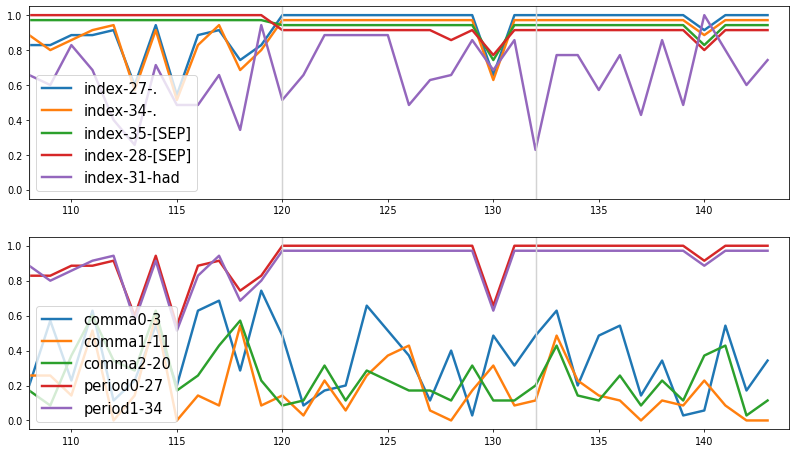

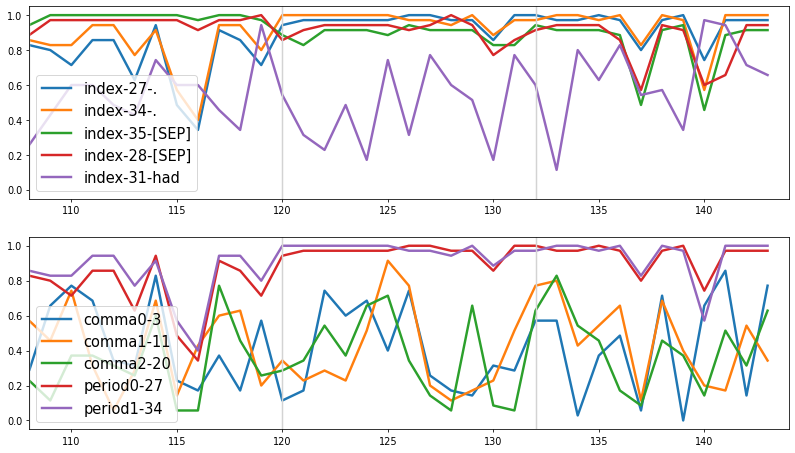

In [165]:
for dict_list in [teacher_list, student_list]:
    fig, [ax1,ax2] = plt.subplots(2, 1, figsize=(14, 8), dpi=70)
    
    # fig, ax1 = plt.subplots(1, 1, figsize=(14, 5), dpi=70)
    color_list = ["b", "c", "tab:blue", "tab:orange", "crimson", "red"]
    punc_name = ["comma", "comma", "comma", "period", "period"]
    # ax.plot(list(range(layer_num*head_num)), dict_list["sep_0"], label="sep_0", color='gray')
    # ax.plot(list(range(layer_num*head_num)), dict_list["sep_1"], label="sep_1", color='gray')
    # ax.plot(list(range(layer_num*head_num)), dict_list["cls"], label="cls", color='tab:brown')
    
    for i, ol in enumerate(outlier_index):
        ax1.plot(list(range(layer_num*head_num)), dict_list[f"ol_{i}"], label=f"index-{ol}-{tokens[ol]}", linewidth=2.5)
    for i, punc in enumerate(punc_index_1):
        ax2.plot(list(range(layer_num*head_num)), dict_list[f"comma_{i}"], label=f"comma{i}-{punc}", linewidth=2.5)
    for i, punc in enumerate(punc_index_2):
        ax2.plot(list(range(layer_num*head_num)), dict_list[f"period_{i}"], label=f"period{i}-{punc}", linewidth=2.5)
    
    ax1.legend(fontsize=15, loc=3)
    ax2.legend(fontsize=15, loc=3)
    ax1.set_xlim([108,144])
    ax2.set_xlim([108,144])
    
    for l in range(layer_num):
        ax1.axvline(x=l*12, color="lightgray")
        ax2.axvline(x=l*12, color="lightgray")

        


In [287]:
teacher_list = None
student_list = None
student_model = None
student_outputs = None
teacher_outputs = None
with torch.no_grad():
    torch.cuda.empty_cache()

# Norm Based Analysis

In [158]:
norm_func = torch.linalg.norm
layer_num = 6
add = 18
table_tc_prob = [[0] * head_num for i in range(layer_num)]
table_st_prob = [[0] * head_num for i in range(layer_num)]
table_diff_prob = [[0] * head_num for i in range(layer_num)]

table_tc_fx = [[0] * head_num for i in range(layer_num)]
table_st_fx = [[0] * head_num for i in range(layer_num)]
table_diff_fx = [[0] * head_num for i in range(layer_num)]

table_tc_afx = [[0] * head_num for i in range(layer_num)]
table_st_afx = [[0] * head_num for i in range(layer_num)]
table_diff_afx = [[0] * head_num for i in range(layer_num)]

token_index = 54# punc_index[0] # outlier_index[0]

for l in range(layer_num):
    
    tc_prob = teacher_probs[l+add]
    st_prob = student_probs[l+add]
    
    tc_context, tc_output, tc_value, tc_output_hs, tc_norm = teacher_zips[l+add]
    st_context, st_output, st_value, st_output_hs, st_norm = student_zips[l+add]
    
    tc_transformed_norm, tc_weighted_norm, tc_summed_weighted_norm = tc_norm
    st_transformed_norm, st_weighted_norm, st_summed_weighted_norm = st_norm
    
    
    for h in range(head_num):
        table_tc_prob[l][h] = tc_prob[:,h,:,token_index].mean().item()
        table_st_prob[l][h] = st_prob[:,h,:,token_index].mean().item()
        table_diff_prob[l][h] = (tc_prob[:,h,token_index].mean() - st_prob[:,h,token_index].mean()).abs().item()
        
        table_tc_fx[l][h] = norm_func(tc_transformed_norm[:,h,token_index], dim=-1).item()
        table_st_fx[l][h] = norm_func(st_transformed_norm[:,h,token_index], dim=-1).item()
        table_diff_fx[l][h] = (norm_func(tc_transformed_norm[:,h,token_index], dim=-1) - norm_func(st_transformed_norm[:,h,token_index], dim=-1)).abs().item()
        
        table_tc_afx[l][h] = norm_func(tc_weighted_norm[:,h,token_index], dim=-1).item()
        table_st_afx[l][h] = norm_func(st_weighted_norm[:,h,token_index], dim=-1).item()
        table_diff_afx[l][h] = (norm_func(tc_weighted_norm[:,h,token_index,:], dim=-1) - norm_func(st_weighted_norm[:,h,token_index,:], dim=-1)).abs().item()
        
        

        
    

In [2]:
fig, [ax1,ax2,ax3] = plt.subplots(1, 3, figsize=(32,8))

ax1.set_xlabel("head", fontsize=20); ax1.set_ylabel("layer", fontsize=20)
heatmap=ax1.pcolor(table_tc_prob, cmap=plt.cm.Blues)
cb = fig.colorbar(heatmap, ax=ax1)
cb.ax.tick_params(labelsize=20)
ax1.set_title("TC PROB", fontsize=25)

ax2.set_xlabel("head", fontsize=20); ax2.set_ylabel("layer", fontsize=20)
heatmap=ax2.pcolor(table_tc_fx, cmap=plt.cm.Blues)
cb = fig.colorbar(heatmap, ax=ax2)
cb.ax.tick_params(labelsize=20)
ax2.set_title("TC || f(x) ||", fontsize=25)

ax3.set_xlabel("head", fontsize=20); ax3.set_ylabel("layer", fontsize=20)
heatmap=ax3.pcolor(table_tc_afx, cmap=plt.cm.Blues)
cb = fig.colorbar(heatmap, ax=ax3)
cb.ax.tick_params(labelsize=20)
ax3.set_title("TC || af(x) ||", fontsize=25)
        
fig, [ax1,ax2,ax3] = plt.subplots(1, 3, figsize=(32,8))

ax1.set_xlabel("head", fontsize=20); ax1.set_ylabel("layer", fontsize=20)
heatmap=ax1.pcolor(table_st_prob, cmap=plt.cm.Blues)
cb = fig.colorbar(heatmap, ax=ax1)
cb.ax.tick_params(labelsize=20)
ax1.set_title("ST PROB", fontsize=25)

ax2.set_xlabel("head", fontsize=20); ax2.set_ylabel("layer", fontsize=20)
heatmap=ax2.pcolor(table_st_fx, cmap=plt.cm.Blues)
cb = fig.colorbar(heatmap, ax=ax2)
cb.ax.tick_params(labelsize=20)
ax2.set_title("ST || f(x) ||", fontsize=25)

ax3.set_xlabel("head", fontsize=20); ax3.set_ylabel("layer", fontsize=20)
heatmap=ax3.pcolor(table_st_afx, cmap=plt.cm.Blues)
cb = fig.colorbar(heatmap, ax=ax3)
cb.ax.tick_params(labelsize=20)
ax3.set_title("ST || af(x) ||", fontsize=25)


fig, [ax1,ax2,ax3] = plt.subplots(1, 3, figsize=(32,8))

ax1.set_xlabel("head", fontsize=20); ax1.set_ylabel("layer", fontsize=20)
heatmap=ax1.pcolor(table_diff_prob, cmap=plt.cm.Blues)
cb = fig.colorbar(heatmap, ax=ax1)
cb.ax.tick_params(labelsize=20)
ax1.set_title("DIFF PROB", fontsize=25)

ax2.set_xlabel("head", fontsize=20); ax2.set_ylabel("layer", fontsize=20)
heatmap=ax2.pcolor(table_diff_fx, cmap=plt.cm.Blues)
cb = fig.colorbar(heatmap, ax=ax2)
cb.ax.tick_params(labelsize=20)
ax2.set_title("DIFF || f(x) ||", fontsize=25)

ax3.set_xlabel("head", fontsize=20); ax3.set_ylabel("layer", fontsize=20)
heatmap=ax3.pcolor(table_diff_afx, cmap=plt.cm.Blues)
cb = fig.colorbar(heatmap, ax=ax3)
cb.ax.tick_params(labelsize=20)
ax3.set_title("DIFF || af(x) ||", fontsize=25)

        

NameError: name 'plt' is not defined

In [415]:
# Avg Attention
for l in range(layer_num):
    for h in range(head_num):
        token_avg_tc = teacher_probs[l][0,h,:,:].mean(dim=0)
        token_avg_st = student_probs[l][0,h,:,:].mean(dim=0)
        
        # Logging
        for i, sep in enumerate(sep_index):
            teacher_list[f"sep_{i}"].append(token_avg_tc[sep].item())
            student_list[f"sep_{i}"].append(token_avg_st[sep].item())
        
        for i, punc in enumerate(punc_index):
            teacher_list[f"punc_{i}"].append(token_avg_tc[punc].item())
            student_list[f"punc_{i}"].append(token_avg_st[punc].item())
            

In [119]:
tc_weighted_norm.shape

torch.Size([1, 16, 68, 68])

In [ ]:
# This is for Output Save Code
seed=42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
mse_func = MSELoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_dir = "models"
output_dir = "output"

tensor_dir = f"tensor_files/{task_name}"
if not os.path.exists(tensor_dir):
    os.mkdir(tensor_dir)
    
if bert_size == "large":
    model_dir = os.path.join(model_dir, "BERT_large")
    output_dir = os.path.join(output_dir, "BERT_large")

# Teacher Model Build
teacher_model_dir = os.path.join(model_dir,task_name)
teacher_model = BertForSequenceClassification.from_pretrained(teacher_model_dir, num_labels=num_labels)
teacher_model.to(device)
teacher_model.eval()

teacher_outputs = teacher_model(input_ids_sliced.to(device))
torch.save(teacher_outputs, os.path.join(tensor_dir, f"teacher_outputs.pt"))

# Student Model Build
name_1 = "1SB_O"
name_2 = "1SB_M"
model_list = [name_1, name_2]

for st_model_name in model_list:
    
    student_model_dir = os.path.join(output_dir, task_name, "exploration", st_model_name)   
    student_config = BertConfig.from_pretrained(student_model_dir)             
    student_model = QuantBertForSequenceClassification.from_pretrained(student_model_dir, config = student_config, num_labels=num_labels)
    student_model.to(device)
    student_model.eval()

    student_outputs  = student_model(input_ids_sliced.to(device), teacher_outputs=None)
    torch.save(student_outputs, os.path.join(tensor_dir, f"{st_model_name}_student_outputs.pt"))
    
    
file_name = "1SB_M"

# Load
teacher_logits, teacher_atts, teacher_reps, teacher_probs, teacher_zip = torch.load(f"tensor_files/{task_name}/teacher_outputs.pt")
student_logits, student_atts, student_reps, student_probs, student_zip = torch.load(f"tensor_files/{task_name}/{file_name}_student_outputs.pt")

In [ ]:
norm_func = torch.linalg.norm
layer_num = 6
add = 6
table_tc_prob = [[0] * head_num for i in range(layer_num)]
table_st_prob = [[0] * head_num for i in range(layer_num)]
table_diff_prob = [[0] * head_num for i in range(layer_num)]

table_tc_value = [[0] * head_num for i in range(layer_num)]
table_st_value = [[0] * head_num for i in range(layer_num)]
table_diff_value = [[0] * head_num for i in range(layer_num)]

table_tc_context = [[0] * head_num for i in range(layer_num)]
table_st_context = [[0] * head_num for i in range(layer_num)]
table_diff_context = [[0] * head_num for i in range(layer_num)]

table_tc_output = [[0] for i in range(layer_num)]
table_st_output = [[0]  for i in range(layer_num)]
table_diff_output = [[0]  for i in range(layer_num)]

token_index = 0 # outlier_index[0]

for l in range(layer_num):
    
    tc_prob = teacher_probs[l+add]
    st_prob = student_probs[l+add]
    
    tc_context, tc_output, tc_value, tc_output_hs, tc_norm = teacher_zips[l+add]
    st_context, st_output, st_value, st_output_hs, st_norm = student_zips[l+add]
    
    tc_tranformed_norm, tc_weighted_norm, tc_summed_weighted_norm = tc_norm
    st_tranformed_norm, st_weighted_norm, st_summed_weighted_norm = st_norm
    
    
    for h in range(head_num):
        table_tc_prob[l][h] = tc_prob[:,h,:,token_index].mean().item()
        table_st_prob[l][h] = st_prob[:,h,:,token_index].mean().item()
        table_diff_prob[l][h] = (tc_prob[:,h,:,token_index].mean() - st_prob[:,h,:,token_index].mean()).abs().item()
        
        table_tc_value[l][h] = norm_func(tc_value[:,h,token_index,:], dim=-1).item()
        table_st_value[l][h] = norm_func(st_value[:,h,token_index,:], dim=-1).item()
        table_diff_value[l][h] = (norm_func(tc_value[:,h,token_index,:], dim=-1) - norm_func(st_value[:,h,token_index,:], dim=-1)).abs().item()
        
        table_tc_context[l][h] = norm_func(tc_context[:,h,token_index,:], dim=-1).item()
        table_st_context[l][h] = norm_func(st_context[:,h,token_index,:], dim=-1).item()
        table_diff_context[l][h] = (norm_func(tc_context[:,h,token_index,:], dim=-1) - norm_func(st_context[:,h,token_index,:], dim=-1)).abs().item()
        
    table_tc_output[l] = norm_func(tc_output[:,token_index,:], dim=-1).item()
    table_st_output[l] = norm_func(st_output[:,token_index,:], dim=-1).item()
    table_diff_output[l] = (norm_func(tc_output[:,token_index,:], dim=-1) - norm_func(st_output[:,token_index,:], dim=-1)).abs().item()
    
        

        
    

In [ ]:
kl_loss = torch.nn.KLDivLoss(reduction="batchmean")
mse_func = MSELoss()

map_diff_map = []
map_diff_output = []

value_diff_map = []
value_diff_output = []

context_diff_map = []
context_diff_output = []

output_diff_map = []
output_diff_output = []

ffn_diff_map = []
ffn_diff_output = []

teacher_model_dir = os.path.join(model_dir,task_name)
teacher_model = BertForSequenceClassification.from_pretrained(teacher_model_dir, num_labels=num_labels)
teacher_model.to(device)
teacher_model.eval()

teacher_outputs = teacher_model(input_ids_sliced.to(device))
teacher_logits, teacher_atts, teacher_reps, teacher_probs, teacher_zip = teacher_outputs

for st_model_name in ["1SB_O", "1SB_M_O"]:
    student_model_dir = os.path.join(output_dir, task_name, "exploration", st_model_name)   
    student_config = BertConfig.from_pretrained(student_model_dir)             
    student_model = QuantBertForSequenceClassification.from_pretrained(student_model_dir, config = student_config, num_labels=num_labels)
    student_model.to(device)
    
    student_outputs  = student_model(input_ids_sliced.to(device), teacher_outputs=None)
    student_logits, student_atts, student_reps, student_probs, student_zip = student_outputs
    
    for l in range(layer_num):
        tc_prob = teacher_probs[l]
        st_prob = student_probs[l]
        
        tc_ffn = teacher_reps[l]
        st_ffn = student_reps[l]
        
        tc_context, tc_output, tc_value, tc_output_hs, tc_norm = teacher_zip[l]
        st_context, st_output, st_value, st_output_hs, st_norm = student_zip[l]

        tc_transformed_norm, tc_weighted_norm, tc_summed_weighted_norm = tc_norm
        st_transformed_norm, st_weighted_norm, st_summed_weighted_norm = st_norm

        ffn_diff = mse_func(tc_ffn[0,:,:], st_ffn[0,:,:])
        output_diff = mse_func(tc_value[0,:,:], st_value[0,:,:])
        
        if "1SB_O" == st_model_name:
            ffn_diff_output.append(ffn_diff.item())
            output_diff_output.append(output_diff.item())
        else:
            ffn_diff_map.append(ffn_diff.item())
            output_diff_map.append(output_diff.item())
            
        for h in range(head_num):
            map_diff = kl_loss(st_prob[0,h,:,:].log(), tc_prob[0,h,:,:])
            value_diff = mse_func(tc_value[0,h,:,:], st_value[0,h,:,:])
            context_diff = mse_func(tc_context[0,h,:,:], st_context[0,h,:,:])
            
            if "1SB_O" == st_model_name:
                map_diff_output.append(map_diff.item())
                value_diff_output.append(value_diff.item())
                context_diff_output.append(context_diff.item())
            else:
                map_diff_map.append(map_diff.item())
                value_diff_map.append(value_diff.item())
                context_diff_map.append(context_diff.item())
            
fig, [ax1,ax2,ax3] = plt.subplots(3, 1, figsize=(14, 12), dpi=70)
x_len = layer_num*head_num
ax1.plot(list(range(x_len)),map_diff_map, linewidth=2.5 )
ax1.plot(list(range(x_len)),map_diff_output, linewidth=2.5 )

ax2.plot(list(range(x_len)),value_diff_map, linewidth=2.5 )
ax2.plot(list(range(x_len)),value_diff_output, linewidth=2.5 )

ax3.plot(list(range(x_len)),context_diff_map, linewidth=2.5 )
ax3.plot(list(range(x_len)),context_diff_output, linewidth=2.5 )

fig, [ax1,ax2] = plt.subplots(2, 1, figsize=(14, 8), dpi=70)
x_len = layer_num
ax1.plot(list(range(x_len)),ffn_diff_map, linewidth=2.5 )
ax1.plot(list(range(x_len)),ffn_diff_output, linewidth=2.5 )

ax2.plot(list(range(x_len)),output_diff_map, linewidth=2.5 )
ax2.plot(list(range(x_len)),output_diff_output, linewidth=2.5 )




In [ ]:
plt.figure(figsize=(10, 5), dpi=70)
i = 0
fs = 15
# for a in [prob_other_diff, prob_cls_diff, prob_sep_diff, prob_punc_diff]:
# label = ["Output", "Map"]
for a in [diff_dict["0_prob_"]]:
    plt.plot(list(range(layer_num)), a, label=label[i], linewidth=2.5)
    i += 1
    
plt.xlabel("Layer", fontsize=fs)
plt.ylabel("Avg. $α$", fontsize=fs)
plt.title("Average attention weight", fontsize=fs)
plt.legend()
plt.show() 

plt.figure(figsize=(10, 5), dpi=70)
i = 0
# for a in [tr_other_diff, tr_cls_diff, tr_sep_diff, tr_punc_diff]:
for a in [tr_punc_diff]:
    plt.plot(list(range(layer_num)), a, label=label[i], linewidth=2.5)
    i += 1
    
plt.xlabel("Layer", fontsize=fs)
plt.ylabel("Avg. ||f(x)||", fontsize=fs)
plt.title("Average Norm || f(x)||", fontsize=fs)
plt.legend()
plt.show() 

plt.figure(figsize=(10, 5), dpi=70)
i = 0
# for a in [wt_other_diff, wt_cls_diff, wt_sep_diff, wt_punc_diff]:
for a in [wt_punc_diff]:
    plt.plot(list(range(layer_num)), a, label=label[i], linewidth=2.5)
    i += 1
    
plt.xlabel("Layer", fontsize=fs)
plt.ylabel("Avg. || $α$ f(x) ||", fontsize=fs)
plt.title("Average Norm || $α$ f(x) ||", fontsize=fs)
plt.legend()
plt.show() 
